# More features

In [89]:
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import pyomo.environ as po

from oemof.solph import (Sink, Source, Transformer, Bus, Flow, Model,
                         EnergySystem, Investment, NonConvex)
import oemof.outputlib as outputlib
import oemof.solph as solph
import oemof.graph as graph
from oemof.tools import economics

solver = 'cbc'

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]

In [90]:
color_dict ={
             'coal': '#755d5d',
             'gas': '#c76c56',
             'oil': '#494a19',
             'lignite': '#56201d',
             'wind': '#4ca7c3',
             'pv': '#ffde32',
             'excess_el': '#9a9da1',
             'pp_coal': '#755d5d',
             'pp_gas': '#c76c56',
             'pp_chp': '#eeac7e',
             'b_heat_source': '#cd3333',
             'heat_source': '#cd3333',
             'heat_pump': '#42c77a',
             'electricity': '#0079ff',
             'demand_el': '#0079ff',
             'shortage_el': '#ff2626',
             'excess_el': '#ff2626',
             'biomass': '#01b42e',
             'pp_biomass': '#01b42e'}

In [91]:
def draw_graph(energysystem, edge_labels=True, node_color='#eeac7e',
               edge_color='#eeac7e', plot=True, node_size=5500,
               with_labels=True, arrows=True, layout='dot'):
    
    grph = graph.create_nx_graph(energysystem)
    
    if type(node_color) is dict:
        node_color = [node_color.get(g, '#AFAFAF') for g in grph.nodes()]

    # set drawing options
    options = {
     'prog': 'dot',
     'with_labels': with_labels,
     'node_color': node_color,
     'edge_color': edge_color,
     'node_size': node_size,
     'arrows': arrows,
     'font_size': 12,
     'font_color': 'w'
    }

    # draw graph
    pos = nx.drawing.nx_agraph.graphviz_layout(grph, prog=layout)

    nx.draw(grph, pos=pos, **options)

    # add edge labels for all edges
    if edge_labels is True and plt:
        labels = nx.get_edge_attributes(grph, 'weight')
        nx.draw_networkx_edge_labels(grph, pos=pos, edge_labels=labels)

    # show output
    if plot is True:
        plt.show()

def initialize_basic_energysystem():
    # initialize and provide data
    datetimeindex = pd.date_range('1/1/2016', periods=240, freq='H')
    filename = 'input_data.csv'
    data = pd.read_csv(filename, sep=',')
    energysystem = EnergySystem(timeindex=datetimeindex)

    # buses
    bcoal = Bus(label='coal', balanced=False)
    bgas = Bus(label='gas', balanced=False)
    bel = Bus(label='electricity')
    energysystem.add(bcoal, bgas, bel)

    # sources
    energysystem.add(Source(label='wind', outputs={bel: Flow(
        actual_value=data['wind'], nominal_value=66.3, fixed=True)}))

    energysystem.add(Source(label='pv', outputs={bel: Flow(
        actual_value=data['pv'], nominal_value=65.3, fixed=True)}))

    # excess and shortage to avoid infeasibilies
    energysystem.add(Sink(label='excess_el', inputs={bel: Flow()}))
    energysystem.add(Source(label='shortage_el',
                         outputs={bel: Flow(variable_costs=100000)}))

    # demands (electricity/heat)
    energysystem.add(Sink(label='demand_el', inputs={bel: Flow(
        nominal_value=85, actual_value=data['demand_el'], fixed=True)}))
    
    return bcoal, bgas, bel, energysystem


def postprocess_and_plot(optimization_model):
    results = outputlib.processing.results(optimization_model)

    results_el = outputlib.views.node(results, 'electricity')

    el_sequences = results_el['sequences']

    to_el = {key[0][0]: key for key in el_sequences.keys() if key[0][1] == 'electricity' and key[1] == 'flow'}
    to_el = [to_el.pop('pv'), to_el.pop('wind')] + list(to_el.values())
    el_prod = el_sequences[to_el]

    fig, ax = plt.subplots(figsize=(14, 3))
    for key in el_sequences.keys():
        color_dict[key] = color_dict[key[0][0]]
    c=[color_dict.get(x, '#333333') for x in el_prod.columns]
    el_prod.plot.area(ax=ax, color=c)
    el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
    legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

### Class Nonconvex: Minimum load

In [106]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

pp_gas = solph.Transformer(label='pp_gas',
                           inputs={bgas: Flow()},
                           outputs={bel: Flow(nominal_value=80,
                                              nonconvex=NonConvex(),
                                              min=0.5)},
                           conversion_factors={bel: 0.3})

energysystem.add(pp_gas)

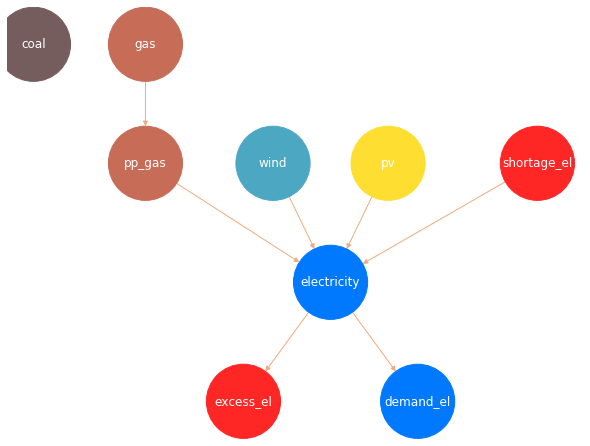

In [107]:
draw_graph(energysystem, node_color=color_dict)

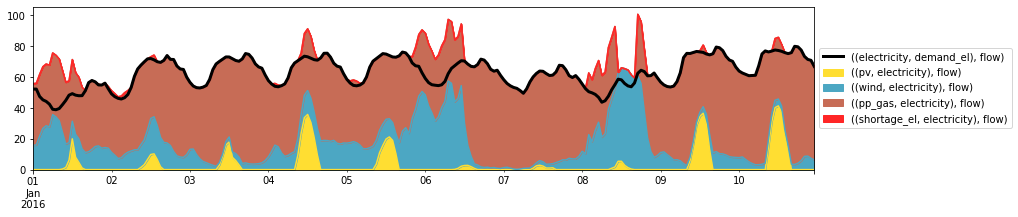

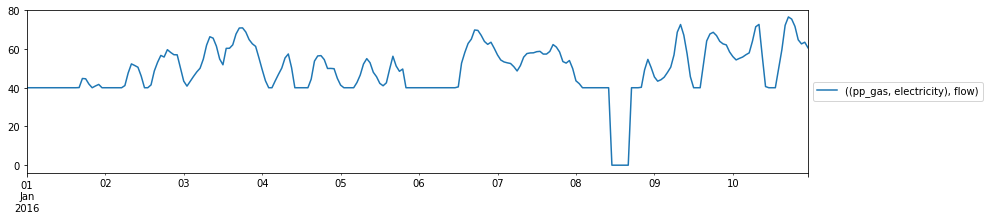

In [108]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False}, cmdline_options={'AllowableGap': 0.01})

postprocess_and_plot(optimization_model)

results = outputlib.processing.convert_keys_to_strings(outputlib.processing.results(optimization_model))

fig2, ax2 = plt.subplots(figsize=(14, 3))
results[('pp_gas','electricity')]['sequences']['flow'].plot(ax=ax2, label=(('pp_gas','electricity'),'flow'))
legend = ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Startup costs

In [132]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

pp_gas = Source(label='pp_gas',
                 outputs={bel: solph.Flow(nominal_value=30,
                                          variable_costs=15)})

# shutdown costs only work in combination with a minimum load
# since otherwise the status variable is "allowed" to be active i.e.
# it permanently has a value of one which does not allow to set the shutdown
# variable which is set to one if the status variable changes from one to zero

pp_coal = Source(label='pp_coal',
                outputs={bel: solph.Flow(nominal_value=60, 
                                         min=0.5, 
                                         max=1.0, 
                                         variable_costs=10,
                                         nonconvex=solph.NonConvex(startup_costs=800,
                                                                   shutdown_costs=800))})

energysystem.add(pp_coal, pp_gas)

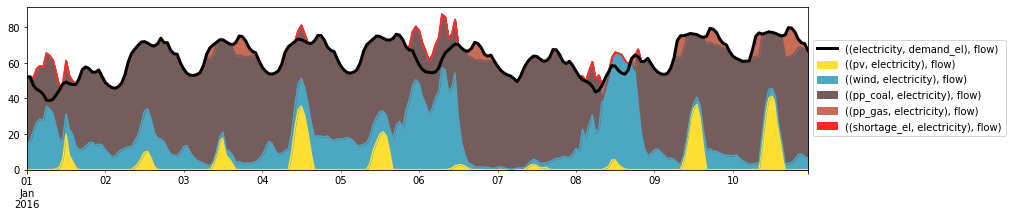

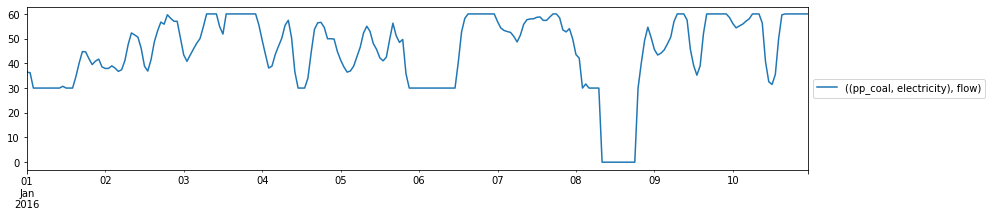

In [133]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

postprocess_and_plot(optimization_model)

results = outputlib.processing.convert_keys_to_strings(outputlib.processing.results(optimization_model))

fig2, ax2 = plt.subplots(figsize=(14, 3))
results[('pp_coal','electricity')]['sequences']['flow'].plot(ax=ax2, label=(('pp_coal','electricity'),'flow'))
legend = ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Minimum up and down times

In [153]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

pp_coal = Source(label='pp_coal',
                 outputs={bel: solph.Flow(nominal_value=60,
                                          min=0.5,
                                          max=1.0,
                                          variable_costs=10,
                                          nonconvex=solph.NonConvex(minimum_downtime=48,
                                                                    initial_status=0))})

pp_gas = Source(label='pp_gas',
                outputs={bel: solph.Flow(nominal_value=60,
                                         min=0.5,
                                         max=1.0,
                                         variable_costs=10,
                                         nonconvex=solph.NonConvex(minimum_uptime=48,
                                                                   initial_status=1))})

energysystem.add(pp_coal, pp_gas)

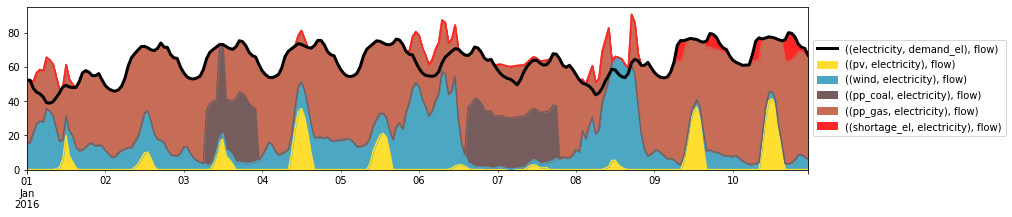

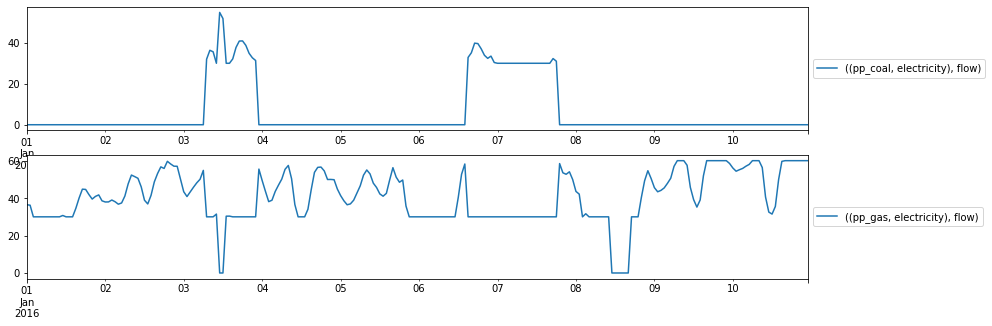

In [154]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

postprocess_and_plot(optimization_model)

results = outputlib.processing.convert_keys_to_strings(outputlib.processing.results(optimization_model))

fig2, axes = plt.subplots(2, 1, figsize=(14, 5))
results[('pp_coal','electricity')]['sequences']['flow'].plot(ax=axes[0], label=(('pp_coal','electricity'),'flow'))
results[('pp_gas','electricity')]['sequences']['flow'].plot(ax=axes[1], label=(('pp_gas','electricity'),'flow'))
for i in [0, 1]:
    axes[i].legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Additional constraints
### Emission constraints

In [156]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(nominal_value=20.2, variable_costs=25)},
    conversion_factors={bel: 0.39}))

pp_gas = Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=41, variable_costs=40)},
    conversion_factors={bel: 0.50})
energysystem.add(pp_gas)

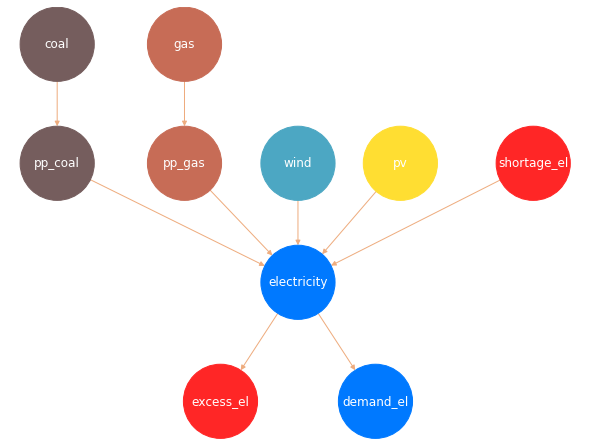

In [157]:
draw_graph(energysystem, node_color=color_dict)

In [168]:
# create the model
optimization_model = Model(energysystem)

emission_limit = 8000
emission_factor = {}
emission_factor['gas'] = 0.27 # t/MWh
emission_factor['coal'] = 0.39 # t/MWh

# add specific emission values to flow objects if source is a commodity bus
for s, t in optimization_model.flows.keys():
    if s is bgas:
        optimization_model.flows[s, t].emission_factor = emission_factor['gas']
    if s is bcoal:
        optimization_model.flows[s, t].emission_factor = emission_factor['coal']

# Add a new pyomo Block
myblock = po.Block()

# pyomo does not need a po.Set, we can use a simple list as well
myblock.COMMODITYFLOWS = [k for (k, v) in optimization_model.flows.items()
                          if hasattr(v, 'emission_factor')]

# add emission constraint
myblock.emission_constr = po.Constraint(expr=(
        sum(optimization_model.flow[i, o, t] *
            optimization_model.flows[i, o].emission_factor
            for (i, o) in myblock.COMMODITYFLOWS
            for t in optimization_model.TIMESTEPS) <= emission_limit))

# add the sub-model to the oemof Model instance
optimization_model.add_component('MyBlock', myblock)

Emissions:  {'coal': 4519.7347266629995, 'gas': 3245.9474581830004}
Total emissions:  7765.682184846


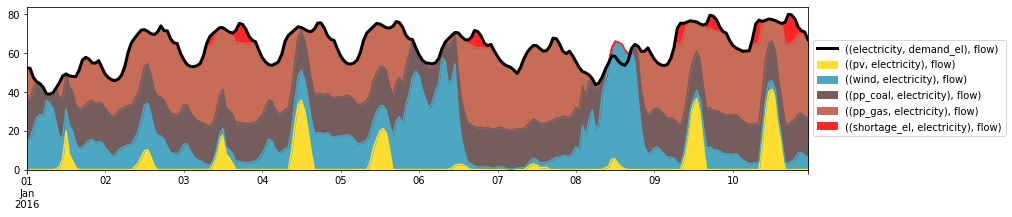

In [169]:
# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

postprocess_and_plot(optimization_model)

results = outputlib.processing.convert_keys_to_strings(outputlib.processing.results(optimization_model))
emissions = {k[0]: v['sequences']['flow'].sum() * emission_factor[k[0]] for k, v in results.items() if (k[0] == 'gas') or (k[0] == 'coal')}

print('Emissions: ', emissions)
print('Total emissions: ', sum(emissions.values()))

In [170]:
myblock.display()

Block MyBlock

  Variables:
    None

  Objectives:
    None

  Constraints:
    emission_constr : Size=1
        Key  : Lower : Body              : Upper
        None :  None : 7765.682184846012 : 8000.0


In [172]:
# for v in optimization_model.component_objects(po.Constraint, descend_into=True):
#     print("FOUND VAR:" + v.name)
#     print('\n    ')
#     v.pprint()
#     print('\n    ')

### Overall investment constraint

new capacity: 
  pp_coal 30.0
  pp_gas 41.079947

annualized costs :
  pp_coal 24072.776157207387
  pp_gas 65927.22457872954
  sum:  90000.00073593692


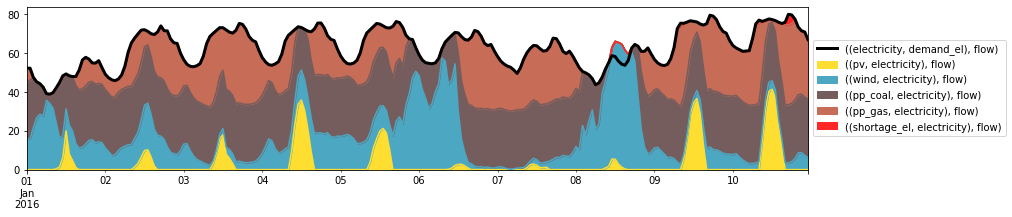

In [176]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

investment_max = 90000

epc_c = economics.annuity(capex=10000, n=20, wacc=0.05)
epc_g = economics.annuity(capex=20000, n=20, wacc=0.05)

# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(investment=solph.Investment(ep_costs=epc_c, maximum=30),
                       variable_costs=25)},
    conversion_factors={bel: 0.39}))

pp_gas = Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(investment=solph.Investment(ep_costs=epc_g),
                        variable_costs=40)},
    conversion_factors={bel: 0.50})
energysystem.add(pp_gas)

# create the model
optimization_model = Model(energysystem)

solph.constraints.investment_limit(optimization_model, investment_max)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

postprocess_and_plot(optimization_model)

results = outputlib.processing.convert_keys_to_strings(outputlib.processing.results(optimization_model))
new_capacity = {k[0]: v['scalars'][0] for k, v in results.items() if (k[0] == 'pp_gas') or (k[0] == 'pp_coal')}

costs = {}
costs['pp_coal'] = new_capacity['pp_coal'] * epc_c
costs['pp_gas'] = new_capacity['pp_gas'] * epc_g
print('new capacity: ')
for k, v in new_capacity.items():
    print(' ', k, v)
print('\nannualized costs :')
for k, v in costs.items():
    print(' ', k, v)
print('  sum: ', sum(costs.values()))